# ndarray对象的内部机理
<br> NumPy的ndarray提供了一种将同质数据块（可以是连续或跨越）解释为多维数组对象的方式。数据类型（dtype）决定了数据的解释方式，比如浮点数、整数、布尔值等。
<br> ndarray如此强大的部分原因是所有数组对象都是数据块的一个跨度视图（strided view）。
<br> ndarray不只是一块内存和一个dtype，它还有跨度信息，这使得数组能以各种步幅（step size）在内存中移动。
<br> ndarray内部由以下内容组成：
* 一个指向数据（内存或内存映射文件中的一块数据）的指针。
* 数据类型或dtype，描述在数组中的固定大小值的格子。
* 一个表示数组形状（shape）的元组。
* 一个跨度元组（stride），其中的整数指的是为了前进到当前维度下一个元素需要“跨过”的字节数。

<div align=center>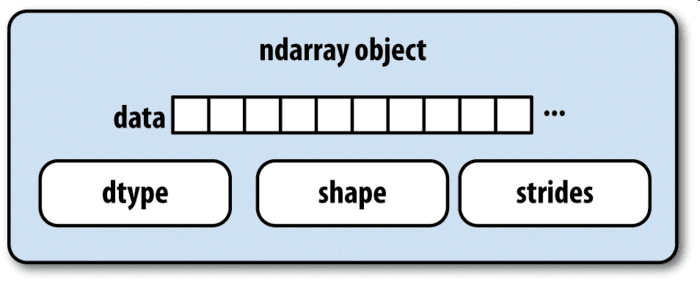
Numpy的ndarray对象的内部结构</div>

In [1]:
import numpy as np

In [2]:
np.ones((2,3)).shape

(2, 3)

一个典型的（C顺序，稍后将详细讲解）3×4×5的float64（8个字节）数组，其跨度为(160,40,8)，通常，跨度在一个轴上越大，沿这个轴进行计算的开销就越大：

In [3]:
np.ones((3,4,5),dtype=np.float64).strides

(160, 40, 8)

# NumPy数据类型体系
你可能偶尔需要检查数组中所包含的是否是整数、浮点数、字符串或Python对象。因为浮点数的种类很多（从float16到float128），判断dtype是否属于某个大类的工作非常繁琐。幸运的是，dtype都有一个超类（比如np.integer和np.floating），它们可以跟np.issubdtype函数结合使用：

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
ints=np.ones((10,),dtype=np.uint16)
floats=np.ones((10,),dtype=np.float16)
np.issubdtype(ints.dtype,np.integer)
np.issubdtype(floats.dtype,np.floating)

True

True

调用dtype的mro方法即可查看其所有的父类：

In [6]:
np.float16.mro()

[numpy.float16,
 numpy.floating,
 numpy.inexact,
 numpy.number,
 numpy.generic,
 object]

In [7]:
np.issubdtype(ints.dtype,np.number)

True

<div align=center style='font-size:16px'>NumPy的dtype体系以及父子类关系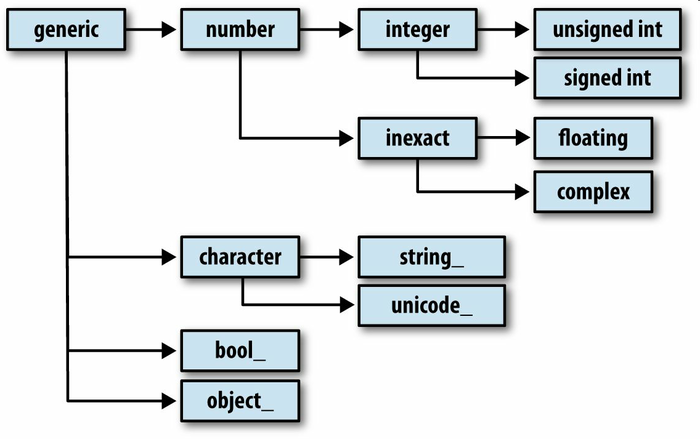</div>

# 高级数组操作
除花式索引、切片、布尔条件取子集等操作之外，数组的操作方式还有很多。虽然pandas中的高级函数可以处理数据分析工作中的许多重型任务，但有时你还是需要编写一些在现有库中找不到的数据算法。
# 数组重塑
多数情况下，你可以无需复制任何数据，就将数组从一个形状转换为另一个形状。只需向数组的实例方法reshape传入一个表示新形状的元组即可实现该目的。

In [8]:
a=np.arange(12)
a
a.reshape((3,4))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [9]:
a.reshape((4,3),order='C')
a.reshape((4,3),order='F')

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

array([[ 0,  4,  8],
       [ 1,  5,  9],
       [ 2,  6, 10],
       [ 3,  7, 11]])

 <div style="text-align: center;font-size:14px">按C顺序（按行）和按Fortran顺序（按列）进行重塑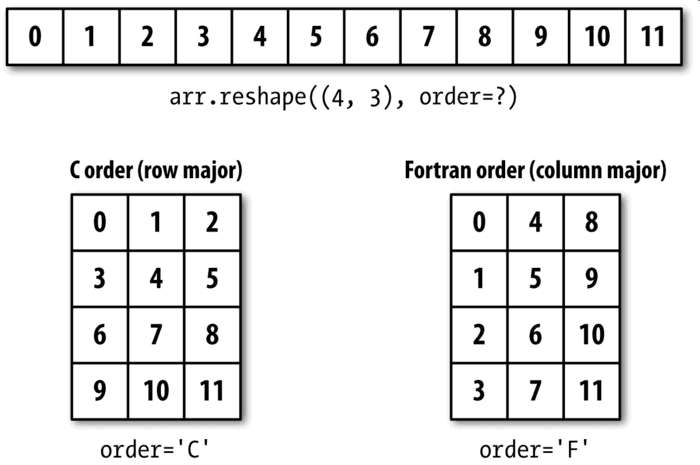</div>

多维数组也能被重塑

In [10]:
a=np.arange(12).reshape((3,4))
a
a.reshape((2,6))

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11]])

作为参数的形状的其中一维可以是－1，它表示该维度的大小由数据本身推断而来：

In [11]:
a.reshape((2,-1))
a.reshape((-1,6))

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11]])

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11]])

与reshape将一维数组转换为多维数组的运算过程相反的运算通常称为扁平化（flattening）或散开（raveling）：

In [12]:
a
a.ravel()
a.flatten()

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

如果结果中的值与原始数组相同，ravel不会产生源数据的副本。flatten方法的行为类似于ravel，只不过它总是返回数据的副本：

# C和Fortran顺序
NumPy允许你更为灵活地控制数据在内存中的布局。默认情况下，NumPy数组是按行优先顺序创建的。在空间方面，这就意味着，对于一个二维数组，每行中的数据项是被存放在相邻内存位置上的。另一种顺序是列优先顺序，它意味着每列中的数据项是被存放在相邻内存位置上的。

由于一些历史原因，行和列优先顺序又分别称为C和Fortran顺序。在FORTRAN 77中，矩阵全都是列优先的。

像reshape和reval这样的函数，都可以接受一个表示数组数据存放顺序的order参数。一般可以是'C'或'F'（还有'A'和'K'等不常用的选项）。


In [13]:
a
a.ravel()
a.ravel(order='F')

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

array([ 0,  4,  8,  1,  5,  9,  2,  6, 10,  3,  7, 11])

C和Fortran顺序的关键区别就是维度的行进顺序：
* C/行优先顺序：先经过更高的维度（例如，轴1会先于轴0被处理）。
* Fortran/列优先顺序：后经过更高的维度（例如，轴0会先于轴1被处理）。

# 数组的合并和拆分
numpy.concatenate可以按指定轴将一个由数组组成的序列（如元组、列表等）连接到一起：

In [14]:
a=np.arange(6).reshape((2,3))
b=np.arange(6,12).reshape((2,3))
np.concatenate([a,b],axis=0)
np.concatenate([a,b],axis=1)

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

array([[ 0,  1,  2,  6,  7,  8],
       [ 3,  4,  5,  9, 10, 11]])

对于常见的连接操作，NumPy提供了一些比较方便的方法（如vstack和hstack）。因此，上面的运算还可以表达为：

In [15]:
np.vstack((a,b))
np.hstack((a,b))

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

array([[ 0,  1,  2,  6,  7,  8],
       [ 3,  4,  5,  9, 10, 11]])

与此相反，split用于将一个数组沿指定轴拆分为多个数组：

传入到np.split的值[x,y]指示在哪个索引处分割数组。

In [16]:
a=np.random.randn(5,2)
a
np.split(a,[1,3],axis=0)

array([[ 1.31811408,  0.68627185],
       [ 1.33952963, -0.32473853],
       [-0.21757532, -1.05826124],
       [-0.81221088, -1.20412746],
       [-0.81786946,  0.38824504]])

[array([[1.31811408, 0.68627185]]), array([[ 1.33952963, -0.32473853],
        [-0.21757532, -1.05826124]]), array([[-0.81221088, -1.20412746],
        [-0.81786946,  0.38824504]])]

 <div style="text-align: center;font-size:14px">关于数组连接和拆分的函数，其中有些是专门为了方便常见的连接运算而提供的。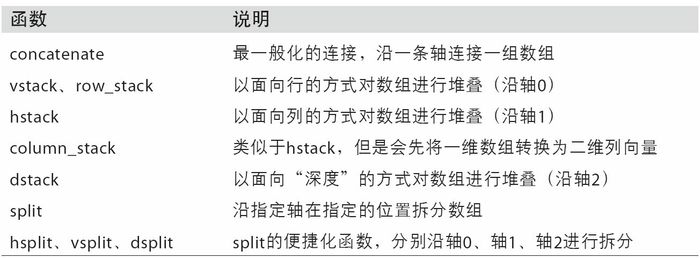</div>

# 堆叠辅助类：r_和c_
NumPy命名空间中有两个特殊的对象——r_和c_，它们可以使数组的堆叠操作更为简洁：

In [17]:
a=np.arange(6)
b=a.reshape((3,2))
c=b+10
np.r_[b,c]
np.c_[np.r_[b,c],a]

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [10, 11],
       [12, 13],
       [14, 15]])

array([[ 0,  1,  0],
       [ 2,  3,  1],
       [ 4,  5,  2],
       [10, 11,  3],
       [12, 13,  4],
       [14, 15,  5]])

它还可以将切片转换成数组

In [18]:
np.c_[1:6,11:16]

array([[ 1, 11],
       [ 2, 12],
       [ 3, 13],
       [ 4, 14],
       [ 5, 15]])

In [19]:
np.r_[1:6,11:16]

array([ 1,  2,  3,  4,  5, 11, 12, 13, 14, 15])

# 元素的重复操作：tile和repeat
对数组进行重复以产生更大数组的工具主要是repeat和tile这两个函数。repeat会将数组中的各个元素重复一定次数，从而产生一个更大的数组：

In [20]:
np.arange(3).repeat(3)

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

对于多维数组，还可以让它们的元素沿指定轴重复：

In [21]:
np.arange(6).reshape((2,3)).repeat(2,axis=0)

array([[0, 1, 2],
       [0, 1, 2],
       [3, 4, 5],
       [3, 4, 5]])

In [22]:
np.arange(6).reshape((2,3)).repeat(2,axis=1)

array([[0, 0, 1, 1, 2, 2],
       [3, 3, 4, 4, 5, 5]])

注意，如果没有设置轴向，则数组会被扁平化，这可能不会是你想要的结果。同样，在对多维进行重复时，也可以传入一组整数，这样就会使各切片重复不同的次数：

In [23]:
np.arange(6).reshape((2,3)).repeat(2)

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5])

In [24]:
np.arange(6).reshape((2,3)).repeat([2,3],axis=0)

array([[0, 1, 2],
       [0, 1, 2],
       [3, 4, 5],
       [3, 4, 5],
       [3, 4, 5]])

In [25]:
np.arange(6).reshape((2,3)).repeat([2,3,4],axis=1)

array([[0, 0, 1, 1, 1, 2, 2, 2, 2],
       [3, 3, 4, 4, 4, 5, 5, 5, 5]])

tile的功能是沿指定轴向堆叠数组的副本。你可以形象地将其想象成“铺瓷砖”：

In [26]:
a=np.arange(6).reshape((2,-1))
a
np.tile(a,2)

array([[0, 1, 2],
       [3, 4, 5]])

array([[0, 1, 2, 0, 1, 2],
       [3, 4, 5, 3, 4, 5]])

第二个参数是瓷砖的数量。对于标量，瓷砖是水平铺设的，而不是垂直铺设。它可以是一个表示“铺设”布局的元组：

In [27]:
np.tile(a,(2,3))

array([[0, 1, 2, 0, 1, 2, 0, 1, 2],
       [3, 4, 5, 3, 4, 5, 3, 4, 5],
       [0, 1, 2, 0, 1, 2, 0, 1, 2],
       [3, 4, 5, 3, 4, 5, 3, 4, 5]])

# 花式索引的等价函数：take和put
获取和设置数组子集的一个办法是通过整数数组使用花式索引

In [28]:
a=np.arange(10)*10
a
ids=[6,5,2]
a[ids]

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

array([60, 50, 20])

ndarray还有其它方法用于获取单个轴向上的选区：

In [29]:
a.take(ids)

array([60, 50, 20])

In [30]:
a.put(ids,1)
a

array([ 0, 10,  1, 30, 40,  1,  1, 70, 80, 90])

In [31]:
a.put(ids,[2,3,4])
a

array([ 0, 10,  4, 30, 40,  3,  2, 70, 80, 90])

要在其它轴上使用take，只需传入axis关键字即可：

In [32]:
a=np.arange(12).reshape((3,-1))
ids=[2,0,1]
a
a.take(ids,axis=0)
a.take(ids,axis=1)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

array([[ 8,  9, 10, 11],
       [ 0,  1,  2,  3],
       [ 4,  5,  6,  7]])

array([[ 2,  0,  1],
       [ 6,  4,  5],
       [10,  8,  9]])

put不接受axis参数，它只会在数组的扁平化版本（一维，C顺序）上进行索引。因此，在需要用其他轴向的索引设置元素时，最好还是使用花式索引。

# 广播

广播（broadcasting）指的是不同形状的数组之间的算术运算的执行方式。它是一种非常强大的功能，但也容易令人误解，即使是经验丰富的老手也是如此。将标量值跟数组合并时就会发生最简单的广播：

In [33]:
a=np.arange(4)
a
a*3

array([0, 1, 2, 3])

array([0, 3, 6, 9])

这里我们说：在这个乘法运算中，标量值5被广播到了其他所有的元素上。

我们可以通过减去列平均值的方式对数组的每一列进行距平化处理。这个问题解决起来非常简单：

In [34]:
a=np.tile(np.arange(4).reshape((4,-1)),(1,3))
a
b=a.mean(0)
b
c=a-b
c

array([[0, 0, 0],
       [1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])

array([1.5, 1.5, 1.5])

array([[-1.5, -1.5, -1.5],
       [-0.5, -0.5, -0.5],
       [ 0.5,  0.5,  0.5],
       [ 1.5,  1.5,  1.5]])

In [35]:
a=np.tile(np.arange(4).reshape((4,1)),(1,3))
a
a+np.arange(1,4)

array([[0, 0, 0],
       [1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])

array([[1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6]])

<div  style="text-align: center;font-size:18px">一维数组在轴0上的广播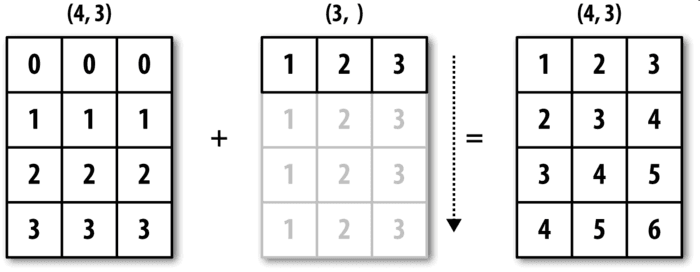<div>

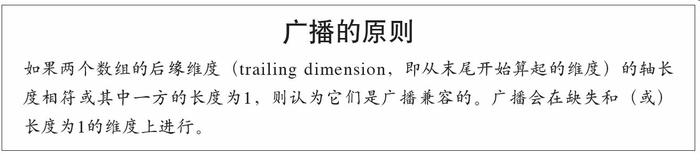

In [36]:
a+np.arange(1,5).reshape((-1,1))

array([[1, 1, 1],
       [3, 3, 3],
       [5, 5, 5],
       [7, 7, 7]])

<div  style="text-align: center;font-size:18px">二维数组在轴1上的广播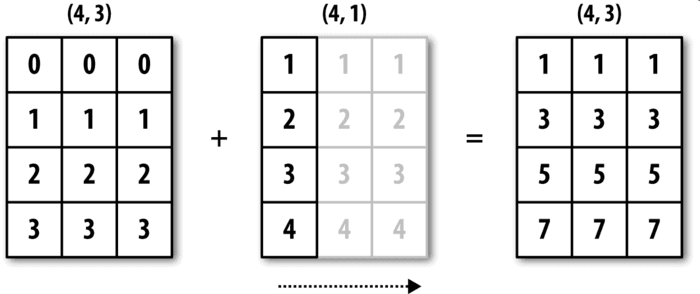</div>

# 沿其它轴向广播
高维度数组的广播似乎更难以理解，而实际上它也是遵循广播原则的。<br>
人们经常需要通过算术运算过程将较低维度的数组在除0轴以外的其他轴向上广播。根据广播的原则，较小数组的“广播维”必须为1。<br>
对于三维的情况，在三维中的任何一维上广播其实也就是将数据重塑为兼容的形状而已。

<div  style="text-align: center;font-size:18px">能在该三维数组上广播的二维数组的形状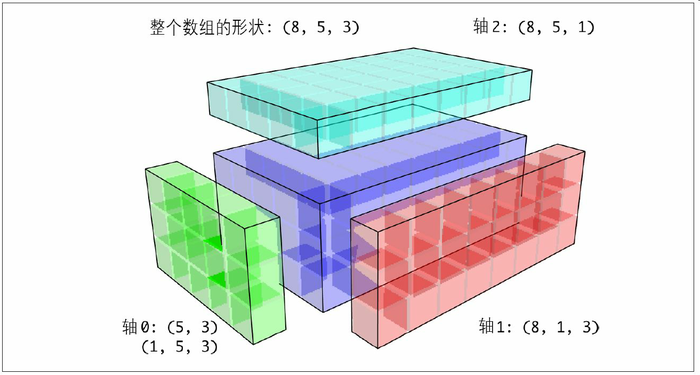</div>
于是就有了一个非常普遍的问题（尤其是在通用算法中），即专门为了广播而添加一个长度为1的新轴。虽然reshape是一个办法，但插入轴需要构造一个表示新形状的元组。NumPy数组提供了一种通过索引机制插入轴的特殊语法:np.newaxis

In [37]:
a=np.arange(6).reshape((3,2))
a.shape
b=a[:,np.newaxis,:]
b.shape

(3, 2)

(3, 1, 2)

In [38]:
data=np.random.randn(2,3,4)
data.shape
data_mean=data.mean(2)
data_mean.shape
res=data-data_mean[:,:,np.newaxis]
res.mean(2)

(2, 3, 4)

(2, 3)

array([[-2.77555756e-17, -4.16333634e-17,  0.00000000e+00],
       [-5.55111512e-17,  2.77555756e-17,  2.77555756e-17]])

# 通过广播设置数组的值
算术运算所遵循的广播原则同样也适用于通过索引机制设置数组值的操作。

In [39]:
a=np.zeros((4,3))
a
a[:]=3
a

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

array([[3., 3., 3.],
       [3., 3., 3.],
       [3., 3., 3.],
       [3., 3., 3.]])

In [40]:
b=np.random.randn(4)
b
b[:,np.newaxis]
a[:]=b[:,np.newaxis]
a

array([ 2.08968559, -1.32163686,  4.15737024, -0.06070761])

array([[ 2.08968559],
       [-1.32163686],
       [ 4.15737024],
       [-0.06070761]])

array([[ 2.08968559,  2.08968559,  2.08968559],
       [-1.32163686, -1.32163686, -1.32163686],
       [ 4.15737024,  4.15737024,  4.15737024],
       [-0.06070761, -0.06070761, -0.06070761]])

# ufunc高级应用
高级用法能使我们丢开循环而编写出更为简洁的代码
# ufunc实例方法
NumPy的各个二元ufunc都有一些用于执行特定矢量化运算的特殊方法。<br>
reduce接受一个数组参数，并通过一系列的二元运算对其值进行聚合（可指明轴向）。<br>
例如，我们可以用np.add.reduce对数组中各个元素进行求和：

In [41]:
a=np.arange(10)
np.add.reduce(a)
np.sum(a)

45

45

如果设置了轴号，约简运算就会沿该轴向执行。这就使你能用一种比较简洁的方式得到某些问题的答案。在下面这个例子中，我们用np.logical_and检查数组各行中的值是否是有序的：

In [42]:
a=np.random.randn(4,4)
a[:,:-1]<a[:,1:]
np.logical_and.reduce(a[:,:-1]<a[:,1:],axis=1)

array([[ True,  True,  True],
       [ True, False, False],
       [ True, False,  True],
       [ True, False,  True]])

array([ True, False, False, False])

ccumulate跟reduce的关系就像cumsum跟sum的关系那样。它产生一个跟原数组大小相同的中间“累计”值数组：

In [43]:
arr = np.arange(15).reshape((3, 5))
arr
np.add.accumulate(arr, axis=1)

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

array([[ 0,  1,  3,  6, 10],
       [ 5, 11, 18, 26, 35],
       [10, 21, 33, 46, 60]], dtype=int32)

outer用于计算两个数组的叉积,outer输出结果的维度是两个输入数据的维度之和：

In [44]:
a=np.arange(3)
b=np.arange(4)
np.multiply.outer(a,b)

array([[0, 0, 0, 0],
       [0, 1, 2, 3],
       [0, 2, 4, 6]])

方法reduceat用于计算“局部约简”，其实就是一个对数据各切片进行聚合的groupby运算。它接受一组用于指示如何对值进行拆分和聚合的“面元边界”：

In [45]:
a=np.arange(10)
np.add.reduceat(a,[0,5,8],)

array([10, 18, 17], dtype=int32)

# 编写新的ufunc
numpy.frompyfunc接受一个Python函数以及两个分别表示输入输出参数数量的参数

In [46]:
def f(a,b):
    return a+b
ff=np.frompyfunc(f,2,1)
ff(np.arange(8),np.arange(8))

array([0, 2, 4, 6, 8, 10, 12, 14], dtype=object)

用frompyfunc创建的函数总是返回Python对象数组。numpy.vectorize。虽然没有frompyfunc那么强大，但可以让你指定输出类型：

In [47]:
fff=np.vectorize(f,otypes=[np.float64])
fff(np.arange(8),np.arange(8))

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14.])

虽然这两个函数提供了一种创建ufunc型函数的手段，但它们非常慢，因为它们在计算每个元素时都要执行一次Python函数调用，这就会比NumPy自带的基于C的ufunc慢很多。<br>
后面，会介绍使用Numba创建快速Python ufuncs。

# 结构化和记录式数组
到目前为止我们所讨论的ndarray都是一种同质数据容器，也就是说，在它所表示的内存块中，各元素占用的字节数相同（具体根据dtype而定）。从表面上看，它似乎不能用于表示异质或表格型的数据。<br>
结构化数组是一种特殊的ndarray，其中的各个元素可以被看做C语言中的结构体（struct，这就是“结构化”的由来）或SQL表中带有多个命名字段的行。

In [48]:
dtype=[('a',np.float64),('b',object)]
a=np.array([(1.1,'trade'),(0.1,'quant')],dtype=dtype)
a

array([(1.1, 'trade'), (0.1, 'quant')], dtype=[('a', '<f8'), ('b', 'O')])

定义结构化dtype（请参考NumPy的在线文档）的方式有很多。最典型的办法是元组列表，各元组的格式为(field_name,field_data_type)。这样，数组的元素就成了元组式的对象，该对象中各个元素可以像字典那样进行访问：

In [49]:
a['b']

array(['trade', 'quant'], dtype=object)

# 嵌套dtype和多维字段
在定义结构化dtype时，你可以再设置一个形状（可以是一个整数，也可以是一个元组）：

In [50]:
dtype=[('a',np.int16,2),('b',np.int32)]
a=np.zeros(3,dtype=dtype)
a

array([([0, 0], 0), ([0, 0], 0), ([0, 0], 0)],
      dtype=[('a', '<i2', (2,)), ('b', '<i4')])

In [51]:
a['a']

array([[0, 0],
       [0, 0],
       [0, 0]], dtype=int16)

这就使你能用单个数组的内存块存放复杂的嵌套结构。你还可以嵌套dtype，作出更复杂的结构。下面是一个简单的例子：

In [52]:
dtype = [('x', [('a', 'f8'), ('b', 'f4')]), ('y', np.int32)]
data = np.array([((1, 2), 5), ((3, 4), 6)], dtype=dtype)
data['x']
data['y']
data['x']['a']

array([(1., 2.), (3., 4.)], dtype=[('a', '<f8'), ('b', '<f4')])

array([5, 6])

array([1., 3.])

# 为什么要用结构化数组
它可以将单个内存块解释为带有任意复杂嵌套列的表格型结构。由于数组中的每个元素在内存中都被表示为固定的字节数，所以结构化数组能够提供非常快速高效的磁盘数据读写（包括内存映像）、网络传输等功能。

# 排序
跟Python内置的列表一样，ndarray的sort实例方法也是就地排序。也就是说，数组内容的重新排列是不会产生新数组的：

In [53]:
a=np.random.randn(5)
a.sort()
a

array([-0.34805983, -0.14180721, -0.12829984,  0.07710775,  2.27297357])

在对数组进行就地排序时要注意一点，如果目标数组只是一个视图，则原始数组将会被修改：

In [54]:
a=np.random.randn(3,4)
a
a[:,0].sort()
a

array([[ 2.86392007,  0.75474512, -0.40986418, -0.91954321],
       [-0.31424165,  1.16215015,  0.43118299,  0.09579616],
       [-1.11433735, -1.70785581, -0.3280794 , -1.21014415]])

array([[-1.11433735,  0.75474512, -0.40986418, -0.91954321],
       [-0.31424165,  1.16215015,  0.43118299,  0.09579616],
       [ 2.86392007, -1.70785581, -0.3280794 , -1.21014415]])

numpy.sort会为原数组创建一个已排序副本。

In [55]:
a=np.random.randn(3,4)
a
np.sort(a,axis=0)
a

array([[-0.01235057, -1.24752673, -0.09136608, -1.0238894 ],
       [-1.7460742 ,  2.07825775, -2.56696615,  0.42947079],
       [ 0.00603453, -1.12177809, -0.99111705, -0.6116665 ]])

array([[-1.7460742 , -1.24752673, -2.56696615, -1.0238894 ],
       [-0.01235057, -1.12177809, -0.99111705, -0.6116665 ],
       [ 0.00603453,  2.07825775, -0.09136608,  0.42947079]])

array([[-0.01235057, -1.24752673, -0.09136608, -1.0238894 ],
       [-1.7460742 ,  2.07825775, -2.56696615,  0.42947079],
       [ 0.00603453, -1.12177809, -0.99111705, -0.6116665 ]])

# 间接排序：argsort和lexsort
在数据分析工作中，常常需要根据一个或多个键对数据集进行排序。argsort和numpy.lexsort就是实现该功能的两个主要方法。

In [56]:
a=np.random.randn(4,5)
a
a[:,a[0,:].argsort()]

array([[ 0.70061742, -0.25275001,  0.02451599,  1.34504298,  0.04729553],
       [-0.74516672,  0.43892943,  0.95410117, -0.79489993,  0.13568139],
       [ 1.15236043, -1.53962826, -1.51697593, -0.25438953, -0.10120712],
       [ 0.52958514,  0.71722129,  0.36889815,  0.21678689, -1.53362606]])

array([[-0.25275001,  0.02451599,  0.04729553,  0.70061742,  1.34504298],
       [ 0.43892943,  0.95410117,  0.13568139, -0.74516672, -0.79489993],
       [-1.53962826, -1.51697593, -0.10120712,  1.15236043, -0.25438953],
       [ 0.71722129,  0.36889815, -1.53362606,  0.52958514,  0.21678689]])

lexsort跟argsort差不多，只不过它可以一次性对多个键数组执行间接排序（字典序）。

In [57]:
a=np.tile(np.arange(3),4)
a
b=np.arange(4).repeat(3)
b
np.lexsort((b,a))

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2])

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3])

array([ 0,  3,  6,  9,  1,  4,  7, 10,  2,  5,  8, 11], dtype=int64)

# 部分排序数组
排序的目的之一可能是确定数组中最大或最小的元素。NumPy有两个优化方法，numpy.partition和np.argpartition，可以在第k个最小元素划分的数组：

In [58]:
a=np.random.randn(20)
a
np.partition(a,3)

array([-1.02516911, -2.1055957 , -1.63417316, -1.12324736,  0.49115115,
       -1.34587006, -0.76870709,  1.86151224,  0.11925185,  0.7481422 ,
        0.67567216,  0.48849427,  1.91799759,  0.11314676, -0.50264303,
        0.03959406, -0.13357665,  1.10874219,  0.65672096, -0.86412737])

array([-2.1055957 , -1.63417316, -1.34587006, -1.12324736, -1.02516911,
       -0.86412737, -0.76870709,  1.86151224,  0.11925185,  0.49115115,
        0.67567216,  0.48849427,  1.91799759,  0.11314676, -0.50264303,
        0.03959406, -0.13357665,  1.10874219,  0.65672096,  0.7481422 ])

当你调用partition(arr, 3)，结果中的头三个元素是最小的三个，没有特定的顺序。numpy.argpartition与numpy.argsort相似，会返回索引，重排数据为等价的顺序：

In [59]:
indices = np.argpartition(a, 3)
indices
a.take(indices)

array([ 1,  2,  5,  3,  0, 19,  6,  7,  8,  4, 10, 11, 12, 13, 14, 15, 16,
       17, 18,  9], dtype=int64)

array([-2.1055957 , -1.63417316, -1.34587006, -1.12324736, -1.02516911,
       -0.86412737, -0.76870709,  1.86151224,  0.11925185,  0.49115115,
        0.67567216,  0.48849427,  1.91799759,  0.11314676, -0.50264303,
        0.03959406, -0.13357665,  1.10874219,  0.65672096,  0.7481422 ])

# 在有序数组中查找元素
searchsorted是一个在有序数组上执行二分查找的数组方法，只要将值插入到它返回的那个位置就能维持数组的有序性：

In [60]:
arr = np.array([0, 1, 7, 12, 15])
arr.searchsorted(9)

3

你可以传入一组值就能得到一组索引：

In [61]:
arr.searchsorted([0, 8, 11, 16])


array([0, 3, 3, 5], dtype=int64)

从上面的结果中可以看出，对于元素0，searchsorted会返回0。这是因为其默认行为是返回相等值组的左侧索引：

再来看searchsorted的另一个用法，假设我们有一个数据数组（其中的值在0到10000之间），还有一个表示“面元边界”的数组，我们希望用它将数据数组拆分开：

In [62]:
data = np.floor(np.random.uniform(0, 10000, size=50))
bins = np.array([0, 100, 1000, 5000, 10000])

然后，为了得到各数据点所属区间的编号（其中1表示面元[0,100)），我们可以直接使用searchsorted：

In [63]:
bins.searchsorted(data)

array([3, 4, 2, 3, 3, 4, 3, 4, 2, 4, 4, 3, 4, 4, 4, 2, 4, 4, 2, 2, 3, 2,
       3, 3, 3, 3, 3, 3, 3, 4, 2, 4, 3, 2, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3,
       3, 3, 2, 3, 3, 4], dtype=int64)

# Numba编写快速NumPy函数
Numba是一个开源项目，它可以利用CPUs、GPUs或其它硬件为类似NumPy的数据创建快速函数。它使用了LLVM项目，将Python代码转换为机器代码。

In [64]:
import numba as nb

In [65]:
def mean_distance(x, y):
    nx = len(x)
    result = 0.0
    count = 0
    for i in range(nx):
        result += x[i] - y[i]
        count += 1
    return result / count
x = np.random.randn(1000000)
y = np.random.randn(1000000)

In [66]:
%timeit mean_distance(x, y)

386 ms ± 27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
%timeit (x-y).mean(0)

5.48 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


NumPy的版本要比它快过很多。我们可以转换这个函数为编译的Numba函数，使用numba.jit函数：

In [68]:
numba_mean_distance=nb.jit(mean_distance)

In [69]:
%timeit numba_mean_distance(x,y)

1.39 ms ± 28.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


它要比矢量化的NumPy快：
Numba不能编译Python代码，但它支持纯Python写的一个部分，可以编写数值算法。

Numba是一个深厚的库，支持多种硬件、编译模式和用户插件。它还可以编译NumPy Python API的一部分，而不用for循环。Numba也可以识别机器编码的结构体，但是若调用CPython API，它就不知道如何编译。Numba的jit函数有一个选项，nopython=True，它限制了可以被转换为Python代码的代码，这些代码可以编译为LLVM，但没有任何Python C API调用。jit(nopython=True)有一个简短的别名numba.njit。

前面的例子，我们还可以这样写：

In [70]:
from numba import float64, njit

@njit(float64(float64[:], float64[:]))
def numba_mean_distance_np(x, y):
    return (x - y).mean()

In [71]:
%timeit numba_mean_distance_np(x,y)

5.59 ms ± 201 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# 用Numba创建自定义numpy.ufunc对象
numba.vectorize创建了一个编译的NumPy ufunc，它与内置的ufunc很像。

In [72]:
from numba import vectorize
@vectorize
def nb_add(a,b):
    return a+b
x=np.arange(10)
nb_add(x,x)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18], dtype=int64)

# 性能建议
使用NumPy的代码的性能一般都很不错，因为数组运算一般都比纯Python循环快得多。下面大致列出了一些需要注意的事项：

* 将Python循环和条件逻辑转换为数组运算和布尔数组运算。
* 尽量使用广播。
* 避免复制数据，尽量使用数组视图（即切片）。
* 利用ufunc及其各种方法。
* 如果单用NumPy无论如何都达不到所需的性能指标，就可以考虑一下用C、Fortran或Cython来编写代码。

# 连续内存的重要性
在某些应用场景中，数组的内存布局可以对计算速度造成极大的影响。这是因为性能差别在一定程度上跟CPU的高速缓存（cache）体系有关。运算过程中访问连续内存块（例如，对以C顺序存储的数组的行求和）一般是最快的，因为内存子系统会将适当的内存块缓存到超高速的L1或L2CPU Cache中。此外，NumPy的C语言基础代码（某些）对连续存储的情况进行了优化处理，这样就能避免一些跨越式的内存访问。

一个数组的内存布局是连续的，就是说元素是以它们在数组中出现的顺序（即Fortran型（列优先）或C型（行优先））存储在内存中的。默认情况下，NumPy数组是以C型连续的方式创建的。列优先的数组（比如C型连续数组的转置）也被称为Fortran型连续。通过ndarray的flags属性即可查看这些信息：

In [73]:
arr_c = np.ones((1000, 1000), order='C')
arr_f = np.ones((1000, 1000), order='F')
arr_c.flags
arr_f.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

在这个例子中，对两个数组的行进行求和计算，理论上说，arr_c会比arr_f快，因为arr_c的行在内存中是连续的。我们可以在IPython中用%timeit来确认一下：

In [74]:
%timeit arr_c.sum(0)
%timeit arr_f.sum(0)

584 µs ± 21.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
963 µs ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


如果想从NumPy中提升性能，这里就应该是下手的地方。如果数组的内存顺序不符合你的要求，使用copy并传入'C'或'F'即可解决该问题：

In [75]:
arr_f.copy('C').flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

注意，在构造数组的视图时，其结果不一定是连续的：

In [76]:
arr_c[:50].flags.contiguous
arr_c[:, :50].flags

True

  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [77]:
arr_c[:, :50].copy('C').flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False